##### Copyright 2025 Google LLC.

In [47]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini Quickstart: Gemini Robotics-ER 1.5
<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/gemini-robotics-er.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

## Gemini Robotics-ER 1.5 Setup

This section will need to be run any time you start up Colab. The example sections following this are intended to be able to be run without reliance on any other example section, so you may skip through to the examples that are most relevant/interesting to you at the time (though it is strongly recommended that you read through each of these examples at least once!)

To run the following cells, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) for an example.

In [48]:
# Install the Google GenAI Python SDK
%pip install -U -q google-genai

In [49]:
# @title Declare imports
import base64
import concurrent.futures
import dataclasses
from io import BytesIO
import json
import textwrap
import time
from typing import Tuple

from google import genai
from google.colab import userdata
from google.genai import types
import IPython
from IPython import display
import ipywidgets as widgets
import numpy as np
from PIL import Image, ImageColor, ImageDraw, ImageFont

In [50]:
# @title Helper Functions

# Json parsing and UI display helpers


def parse_json(json_output):
  # Parsing out the markdown fencing
  lines = json_output.splitlines()
  for i, line in enumerate(lines):
    if line == "```json":
      # Remove everything before "```json"
      json_output = "\n".join(lines[i + 1 :])
      # Remove everything after the closing "```"
      json_output = json_output.split("```")[0]
      break  # Exit the loop once "```json" is found
  return json_output


def generate_point_html(pil_image, points_json):
  buffered = BytesIO()
  pil_image.save(buffered, format="PNG")
  img_str = base64.b64encode(buffered.getvalue()).decode()
  points_json = parse_json(points_json)

  return f"""
<!DOCTYPE html>
<html>
<head>
    <title>Point Visualization</title>
    <style>
        body {{
            margin: 0;
            padding: 0;
            background: #fff;
            color: #000;
            font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, sans-serif;
        }}

        .point-overlay {{
            position: absolute;
            top: 0;
            left: 0;
            width: 100%;
            height: 100%;
            pointer-events: none;
        }}

        .point {{
            position: absolute;
            width: 12px;
            height: 12px;
            background-color: #2962FF;
            border: 2px solid #fff;
            border-radius: 50%;
            transform: translate(-50%, -50%);
            box-shadow: 0 0 40px rgba(41, 98, 255, 0.6);
            opacity: 0;
            transition: all 0.3s ease-in;
            pointer-events: auto;
        }}

        .point.visible {{
            opacity: 1;
        }}

        .point.fade-out {{
            animation: pointFadeOut 0.3s forwards;
        }}

        .point.highlight {{
            transform: translate(-50%, -50%) scale(1.1);
            background-color: #FF4081;
            box-shadow: 0 0 40px rgba(255, 64, 129, 0.6);
            z-index: 100;
        }}

        @keyframes pointFadeOut {{
            from {{
                opacity: 1;
            }}
            to {{
                opacity: 0.7;
            }}
        }}

        .point-label {{
            position: absolute;
            background-color: #2962FF;
            color: #fff;
            font-size: 14px;
            padding: 4px 12px;
            border-radius: 4px;
            transform: translate(20px, -10px);
            white-space: nowrap;
            opacity: 0;
            transition: all 0.3s ease-in;
            box-shadow: 0 0 30px rgba(41, 98, 255, 0.4);
            pointer-events: auto;
            cursor: pointer;
        }}

        .point-label.visible {{
            opacity: 1;
        }}

        .point-label.fade-out {{
            opacity: 0.45;
        }}

        .point-label.highlight {{
            background-color: #FF4081;
            box-shadow: 0 0 30px rgba(255, 64, 129, 0.4);
            transform: translate(20px, -10px) scale(1.1);
            z-index: 100;
        }}
    </style>
</head>
<body>
    <div id="container" style="position: relative;">
        <canvas id="canvas" style="background: #000;"></canvas>
        <div id="pointOverlay" class="point-overlay"></div>
    </div>

    <script>
        function annotatePoints(frame) {{
            // Add points with fade effect
            const pointsData = {points_json};

            const pointOverlay = document.getElementById("pointOverlay");
            pointOverlay.innerHTML = "";

            const points = [];
            const labels = [];

            pointsData.forEach(pointData => {{
                // Skip entries without coodinates.
                if (!(pointData.hasOwnProperty("point")))
                  return;

                const point = document.createElement("div");
                point.className = "point";
                const [y, x] = pointData.point;
                point.style.left = `${{x/1000.0 * 100.0}}%`;
                point.style.top = `${{y/1000.0 * 100.0}}%`;

                const pointLabel = document.createElement("div");
                pointLabel.className = "point-label";
                pointLabel.textContent = pointData.label;
                point.appendChild(pointLabel);

                pointOverlay.appendChild(point);
                points.push(point);
                labels.push(pointLabel);

                setTimeout(() => {{
                    point.classList.add("visible");
                    pointLabel.classList.add("visible");
                }}, 0);

                // Add hover effects
                const handleMouseEnter = () => {{
                    // Highlight current point and label
                    point.classList.add("highlight");
                    pointLabel.classList.add("highlight");

                    // Fade out other points and labels
                    points.forEach((p, idx) => {{
                        if (p !== point) {{
                            p.classList.add("fade-out");
                            labels[idx].classList.add("fade-out");
                        }}
                    }});
                }};

                const handleMouseLeave = () => {{
                    // Remove highlight from current point and label
                    point.classList.remove("highlight");
                    pointLabel.classList.remove("highlight");

                    // Restore other points and labels
                    points.forEach((p, idx) => {{
                        p.classList.remove("fade-out");
                        labels[idx].classList.remove("fade-out");
                    }});
                }};

                point.addEventListener("mouseenter", handleMouseEnter);
                point.addEventListener("mouseleave", handleMouseLeave);
                pointLabel.addEventListener("mouseenter", handleMouseEnter);
                pointLabel.addEventListener("mouseleave", handleMouseLeave);
            }});
        }}

        // Initialize canvas
        const canvas = document.getElementById("canvas");
        const ctx = canvas.getContext("2d");
        const container = document.getElementById("container");

        // Load and draw the image
        const img = new Image();
        img.onload = () => {{
            const aspectRatio = img.height / img.width;
            canvas.width = 800;
            canvas.height = Math.round(800 * aspectRatio);
            container.style.width = canvas.width + "px";
            container.style.height = canvas.height + "px";

            ctx.drawImage(img, 0, 0, canvas.width, canvas.height);

            frame.width = canvas.width;
            frame.height = canvas.height;
            annotatePoints(frame);
        }};
        img.src = "data:image/png;base64,{img_str}";

        const frame = {{
            width: canvas.width,
            height: canvas.height
        }};

        annotatePoints(frame);
    </script>
</body>
</html>
"""


def generate_grasp_html(image, grasp_points, grasp_angles, labels):
  buffered = BytesIO()
  image.save(buffered, format="PNG")
  img_str = base64.b64encode(buffered.getvalue()).decode()

  grasps = []
  for point, angle, label in zip(grasp_points, grasp_angles, labels):
    grasp = [
        point[0],
        point[1],
        -angle,
    ]
    grasps.append({"point": grasp, "label": label})

  return f"""
<!DOCTYPE html>
<html>
<head>
    <title>Point Visualization</title>
    <style>
        body {{
            margin: 0;
            padding: 0;
            background: #fff;
            color: #000;
            font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, sans-serif;
        }}

        .point-overlay {{
            position: absolute;
            top: 0;
            left: 0;
            width: 100%;
            height: 100%;
            pointer-events: none;
        }}

        .point {{
            position: absolute;
            width: 12px;
            height: 12px;
            background-color: #2962FF;
            border: 2px solid #fff;
            border-radius: 50%;
            transform: translate(-50%, -50%);
            box-shadow: 0 0 40px rgba(41, 98, 255, 0.6);
            opacity: 0;
            transition: all 0.3s ease-in;
            pointer-events: auto;
        }}

        .point.visible {{
            opacity: 1;
        }}

        .point.fade-out {{
            animation: pointFadeOut 0.3s forwards;
        }}

        .point.highlight {{
            transform: translate(-50%, -50%) scale(1.1);
            background-color: #FF4081;
            box-shadow: 0 0 40px rgba(255, 64, 129, 0.6);
            z-index: 100;
        }}

        @keyframes pointFadeOut {{
            from {{
                opacity: 1;
            }}
            to {{
                opacity: 0.7;
            }}
        }}

        .point-label {{
            position: absolute;
            background-color: #2962FF;
            color: #fff;
            font-size: 14px;
            padding: 4px 12px;
            border-radius: 4px;
            transform: translate(20px, -10px);
            white-space: nowrap;
            opacity: 0;
            transition: all 0.3s ease-in;
            box-shadow: 0 0 30px rgba(41, 98, 255, 0.4);
            pointer-events: auto;
            cursor: pointer;
        }}

        .point-label.visible {{
            opacity: 1;
        }}

        .point-label.fade-out {{
            opacity: 0.45;
        }}

        .point-label.highlight {{
            background-color: #FF4081;
            box-shadow: 0 0 30px rgba(255, 64, 129, 0.4);
            transform: translate(20px, -10px) scale(1.1);
            z-index: 100;
        }}

        .line {{
            position: absolute;
            height: 3px;
            background-color: #2962FF;
            transform-origin: top left;
            opacity: 0;
            transition: all 0.3s ease-in;
            pointer-events: auto;
        }}

        .line.visible {{
            opacity: 1;
        }}

        .line.fade-out {{
            opacity: 0.45;
        }}

        .line.highlight {{
            transform: translate(-50%, -50%) scale(1.1);
            background-color: #FF4081;
            box-shadow: 0 0 40px rgba(255, 64, 129, 0.6);
            z-index: 100;
        }}

    </style>
</head>
<body>
    <div id="container" style="position: relative;">
        <canvas id="canvas" style="background: #000;"></canvas>
        <div id="pointOverlay" class="point-overlay"></div>
    </div>

    <script>
        function annotatePoints(frame) {{
            // Add points with fade effect
            const pointsData = {grasps};

            const pointOverlay = document.getElementById("pointOverlay");
            pointOverlay.innerHTML = "";

            const points = [];
            const labels = [];

            pointsData.forEach(pointData => {{
                const [y, x, angle] = pointData.point;


                const yAbsolute = y / 1000.0 * frame.height;
                const xAbsolute = x / 1000.0 * frame.width;
                const y0Absolute = yAbsolute - Math.sin(angle / 180 * Math.PI) * 40; // Can change 20 to a higher number for a wider grasp UI
                const x0Absolute = xAbsolute - Math.cos(angle / 180 * Math.PI) * 40; // Can change 20 to a higher number for a wider grasp UI
                const y1Absolute = yAbsolute + Math.sin(angle / 180 * Math.PI) * 40; // Can change 20 to a higher number for a wider grasp UI
                const x1Absolute = xAbsolute + Math.cos(angle / 180 * Math.PI) * 40; // Can change 20 to a higher number for a wider grasp UI

                const point1 = document.createElement("div");
                point1.className = "point";
                point1.style.left = `${{x0Absolute}}px`;
                point1.style.top = `${{y0Absolute}}px`;

                const point2 = document.createElement("div");
                point2.className = "point";
                point2.style.left = `${{x1Absolute}}px`;
                point2.style.top = `${{y1Absolute}}px`;

                const pointLabel = document.createElement("div");
                pointLabel.className = "point-label";
                pointLabel.textContent = pointData.label;
                point2.appendChild(pointLabel);

                const deltaX = x1Absolute - x0Absolute;
                const deltaY = y1Absolute - y0Absolute;
                const length = Math.sqrt(deltaX * deltaX + deltaY * deltaY);

                const line = document.createElement("div");
                line.className = "line";
                line.style.width = `${{length}}px`;
                line.style.left = `${{x0Absolute}}px`;
                line.style.top = `${{y0Absolute}}px`;
                line.style.transform = `rotate(${{angle}}deg)`;

                pointOverlay.appendChild(point1);
                points.push(point1);
                pointOverlay.appendChild(point2);
                points.push(point2);
                pointOverlay.appendChild(line);
                points.push(line)
                labels.push(pointLabel);

                setTimeout(() => {{
                    point1.classList.add("visible");
                    point2.classList.add("visible");
                    line.classList.add("visible");
                    pointLabel.classList.add("visible");
                }}, 0);

                // Add hover effects
                const handleMouseEnter = () => {{
                    // Highlight current point and label
                    point1.classList.add("highlight");
                    point2.classList.add("highlight");
                    line.classList.add("highlight");
                    pointLabel.classList.add("highlight");

                    // Fade out other points and labels
                    points.forEach((p, idx) => {{
                        if (p !== point1 && p !== point2 && p !== line) {{
                            p.classList.add("fade-out");
                        }}
                    }});
                    labels.forEach((l, idx) => {{
                        if (l != pointLabel) {{
                            l.classList.add("fade-out");
                        }}
                    }});
                }};

                const handleMouseLeave = () => {{
                    // Remove highlight from current point and label
                    point1.classList.remove("highlight");
                    point2.classList.remove("highlight");
                    line.classList.remove("highlight");
                    pointLabel.classList.remove("highlight");

                    // Restore other points and labels
                    points.forEach((p, idx) => {{
                        p.classList.remove("fade-out");
                    }});
                    labels.forEach((l, idx) => {{
                        l.classList.remove("fade-out");
                    }});
                }};

                point1.addEventListener("mouseenter", handleMouseEnter);
                point1.addEventListener("mouseleave", handleMouseLeave);
                point2.addEventListener("mouseenter", handleMouseEnter);
                point2.addEventListener("mouseleave", handleMouseLeave);
                line.addEventListener("mouseenter", handleMouseEnter);
                line.addEventListener("mouseleave", handleMouseLeave);
                pointLabel.addEventListener("mouseenter", handleMouseEnter);
                pointLabel.addEventListener("mouseleave", handleMouseLeave);
            }});
        }}

        // Initialize canvas
        const canvas = document.getElementById("canvas");
        const ctx = canvas.getContext("2d");
        const container = document.getElementById("container");

        // Load and draw the image
        const img = new Image();
        img.onload = () => {{
            const aspectRatio = img.height / img.width;
            canvas.width = img.width;
            canvas.height = Math.round(img.width * aspectRatio);
            container.style.width = canvas.width + "px";
            container.style.height = canvas.height + "px";

            ctx.drawImage(img, 0, 0, canvas.width, canvas.height);

            frame.width = canvas.width;
            frame.height = canvas.height;
            annotatePoints(frame);
        }};
        img.src = "data:image/png;base64,{img_str}";

        const frame = {{
            width: canvas.width,
            height: canvas.height
        }};

        annotatePoints(frame);
    </script>
</body>
</html>
"""


def generate_3d_box_html(image, boxes_json):
  buffered = BytesIO()
  image.save(buffered, format="PNG")
  img_str = base64.b64encode(buffered.getvalue()).decode()

  return f"""
<!DOCTYPE html>
<html>
<head>
    <title>3D Box Visualization</title>
    <style>
        body {{
            margin: 0;
            padding: 0;
            background: #fff;
            color: #000;
            font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, sans-serif;
        }}

        .view-container {{
            display: flex;
            gap: 20px;
            padding: 20px;
            flex-direction: column;
            align-items: center;
        }}

        .canvas-container {{
            display: flex;
            gap: 20px;
        }}

        .box-line {{
            position: absolute;
            background: #2962FF;
            transform-origin: 0 0;
            opacity: 1;
            box-shadow: 0 0 30px rgba(41, 98, 255, 0.4);
            transition: all 0.3s ease;
            pointer-events: none;
        }}

        .box-line.highlight {{
            background: #FF4081;
            box-shadow: 0 0 30px rgba(255, 64, 129, 0.4);
            z-index: 100;
            border-color: #FF4081 !important;
        }}

        .box-line.fade {{
            opacity: 0.3;
        }}

        .box-label {{
            position: absolute;
            color: white;
            font-size: 12px;
            font-family: Arial;
            transform: translate(-50%, -50%);
            opacity: 1;
            background: #2962FF;
            padding: 2px 8px;
            border-radius: 4px;
            box-shadow: 0 0 30px rgba(41, 98, 255, 0.4);
            transition: all 0.3s ease;
            cursor: pointer;
            z-index: 1000;
        }}

        .box-label.highlight {{
            background: #FF4081;
            box-shadow: 0 0 30px rgba(255, 64, 129, 0.4);
            transform: translate(-50%, -50%) scale(1.1);
            z-index: 1001;
        }}

        .box-label.fade {{
            opacity: 0.3;
        }}

        .box-overlay {{
            position: absolute;
            top: 0;
            left: 0;
            width: 100%;
            height: 100%;
            pointer-events: none;
        }}

        .box-overlay .box-label {{
            pointer-events: auto;
        }}

        .controls {{
            margin-top: 10px;
            background: rgba(0,0,0,0.7);
            padding: 10px 20px;
            border-radius: 8px;
            display: flex;
            align-items: center;
            gap: 10px;
        }}

        .slider-label {{
            color: white;
            font-size: 12px;
        }}

        input[type="range"] {{
            width: 200px;
        }}

        #topView {{
            width: 500px;
            height: 500px;
            background: #fff;
            border: 1px solid #333;
            position: relative;
            overflow: hidden;
        }}

        .grid-line {{
            position: absolute;
            background: #333333;
            pointer-events: none;
        }}

        .grid-label {{
            position: absolute;
            color: #666666;
            font-size: 10px;
            pointer-events: none;
        }}

        .axis-line {{
            position: absolute;
            background: #666666;
            pointer-events: none;
        }}

        .camera-triangle {{
            position: absolute;
            width: 0;
            height: 0;
            border-left: 10px solid transparent;
            border-right: 10px solid transparent;
            border-bottom: 20px solid #0000ff;
            pointer-events: none;
        }}

        .top-view-container {{
            position: relative;
        }}
    </style>
</head>
<body>
    <div class="view-container">
        <div class="canvas-container">
            <div id="container" style="position: relative;">
                <canvas id="canvas" style="background: #000;"></canvas>
                <div id="boxOverlay" class="box-overlay"></div>
                <div class="controls">
                    <span class="slider-label">FOV:</span>
                    <input type="range" id="fovSlider" min="50" max="120" value="60" step="1">
                    <span id="fovValue">60</span>
                </div>
            </div>
            <div class="top-view-container">
                <div id="topView">
                    <div id="topViewOverlay" class="box-overlay"></div>
                </div>
                <div class="controls">
                    <span class="slider-label">Zoom:</span>
                    <input type="range" id="zoomSlider" min="0.5" max="3" value="1.5" step="0.1">
                    <span id="zoomValue">1.5x</span>
                </div>
            </div>
        </div>
    </div>

    <script>
        let isDragging = {{left: false, right: false}};
        let lastX = 0;
        let lastY = 0;
        let panOffset = {{x: 0, y: 150}};
        let boxesData = {boxes_json};

        const canvas = document.getElementById("canvas");
        const ctx = canvas.getContext("2d");
        const container = document.getElementById("container");
        const topView = document.getElementById("topView");
        const topViewOverlay = document.getElementById("topViewOverlay");

        // Load and draw the image
        const img = new Image();
        img.onload = () => {{
            const aspectRatio = img.height / img.width;
            canvas.height = 500;
            canvas.width = Math.round(500 / aspectRatio);
            container.style.width = canvas.width + "px";
            container.style.height = canvas.height + "px";

            ctx.drawImage(img, 0, 0, canvas.width, canvas.height);

            frame.width = canvas.width;
            frame.height = canvas.height;
            annotateFrame(frame, parseFloat(fovSlider.value));
        }};
        img.src = "data:image/png;base64,{img_str}";

        function highlightBox(label, highlight) {{
            const boxOverlay = document.getElementById("boxOverlay");
            const topViewOverlay = document.getElementById("topViewOverlay");

            [boxOverlay, topViewOverlay].forEach(overlay => {{
                const elements = overlay.querySelectorAll(".box-line, .box-label");

                elements.forEach(element => {{
                    if(element.dataset.label === label) {{
                        if(highlight) {{
                            element.classList.add("highlight");
                            element.classList.remove("fade");
                        }} else {{
                            element.classList.remove("highlight");
                            element.classList.remove("fade");
                        }}
                    }} else {{
                        if(highlight) {{
                            element.classList.add("fade");
                            element.classList.remove("highlight");
                        }} else {{
                            element.classList.remove("fade");
                            element.classList.remove("highlight");
                        }}
                    }}
                }});
            }});
        }}

        function drawTopView() {{
            topViewOverlay.innerHTML = "";

            const zoom = parseFloat(zoomSlider.value);
            const viewWidth = 400;
            const viewHeight = 400;
            const centerX = viewWidth / 2 + panOffset.x;
            const centerY = viewHeight / 2 + panOffset.y;

            for(let x = -5; x <= 5; x++) {{
                const xPixel = centerX + x * (viewWidth/10) * zoom;
                const gridLine = document.createElement("div");
                gridLine.className = "grid-line";
                gridLine.style.left = `${{xPixel}}px`;
                gridLine.style.top = "0";
                gridLine.style.width = "1px";
                gridLine.style.height = "100%";
                topViewOverlay.appendChild(gridLine);

                const label = document.createElement("div");
                label.className = "grid-label";
                label.textContent = x.toString();
                label.style.left = `${{xPixel}}px`;
                label.style.bottom = "5px";
                topViewOverlay.appendChild(label);
            }}

            for(let y = -5; y <= 10; y++) {{
                const yPixel = centerY - y * (viewHeight/10) * zoom;
                const gridLine = document.createElement("div");
                gridLine.className = "grid-line";
                gridLine.style.left = "0";
                gridLine.style.top = `${{yPixel}}px`;
                gridLine.style.width = "100%";
                gridLine.style.height = "1px";
                topViewOverlay.appendChild(gridLine);

                const label = document.createElement("div");
                label.className = "grid-label";
                label.textContent = y.toString();
                label.style.left = "5px";
                label.style.top = `${{yPixel}}px`;
                topViewOverlay.appendChild(label);
            }}

            const xAxis = document.createElement("div");
            xAxis.className = "axis-line";
            xAxis.style.left = `${{centerX}}px`;
            xAxis.style.top = "0";
            xAxis.style.width = "2px";
            xAxis.style.height = "100%";
            topViewOverlay.appendChild(xAxis);

            const yAxis = document.createElement("div");
            yAxis.className = "axis-line";
            yAxis.style.left = "0";
            yAxis.style.top = `${{centerY}}px`;
            yAxis.style.width = "100%";
            yAxis.style.height = "2px";
            topViewOverlay.appendChild(yAxis);

            const camera = document.createElement("div");
            camera.className = "camera-triangle";
            camera.style.left = `${{centerX - 10}}px`;
            camera.style.top = `${{centerY - 20}}px`;
            topViewOverlay.appendChild(camera);

            boxesData.forEach(boxData => {{
                const center = boxData.box_3d.slice(0,3);
                const size = boxData.box_3d.slice(3,6);
                const rpy = boxData.box_3d.slice(6).map(x => x * Math.PI / 180);

                const centerX = viewWidth/2 + center[0] * (viewWidth/10) * zoom + panOffset.x;
                const centerY = viewHeight/2 - center[1] * (viewHeight/10) * zoom + panOffset.y;

                const box = document.createElement("div");
                box.className = "box-line";
                box.dataset.label = boxData.label;
                box.style.width = `${{size[0] * (viewWidth/10) * zoom}}px`;
                box.style.height = `${{size[1] * (viewHeight/10) * zoom}}px`;
                box.style.left = `${{centerX - (size[0] * (viewWidth/20) * zoom)}}px`;
                box.style.top = `${{centerY - (size[1] * (viewHeight/20) * zoom)}}px`;
                box.style.transform = `rotate(${{-rpy[2]}}rad)`;
                box.style.border = "2px solid #2962FF";
                box.style.background = "transparent";
                topViewOverlay.appendChild(box);

                const label = document.createElement("div");
                label.className = "box-label";
                label.dataset.label = boxData.label;
                label.textContent = boxData.label;
                label.style.left = `${{centerX}}px`;
                label.style.top = `${{centerY}}px`;

                label.addEventListener("mouseenter", () => highlightBox(boxData.label, true));
                label.addEventListener("mouseleave", () => highlightBox(boxData.label, false));

                topViewOverlay.appendChild(label);
            }});
        }}

        function annotateFrame(frame, fov) {{
            const boxOverlay = document.getElementById("boxOverlay");
            boxOverlay.innerHTML = "";

            boxesData.forEach(boxData => {{
                const center = boxData.box_3d.slice(0,3);
                const size = boxData.box_3d.slice(3,6);
                const rpy = boxData.box_3d.slice(6).map(x => x * Math.PI / 180);

                const [sr, sp, sy] = rpy.map(x => Math.sin(x/2));
                const [cr, cp, cz] = rpy.map(x => Math.cos(x/2));
                const quaternion = [
                    sr * cp * cz - cr * sp * sy,
                    cr * sp * cz + sr * cp * sy,
                    cr * cp * sy - sr * sp * cz,
                    cr * cp * cz + sr * sp * sy
                ];

                const height = frame.height;
                const width = frame.width;
                const f = width / (2 * Math.tan(fov/2 * Math.PI/180));
                const cx = width/2;
                const cy = height/2;
                const intrinsics = [[f, 0, cx], [0, f, cy], [0, 0, 1]];

                const halfSize = size.map(s => s/2);
                let corners = [];
                for(let x of [-halfSize[0], halfSize[0]]) {{
                    for(let y of [-halfSize[1], halfSize[1]]) {{
                        for(let z of [-halfSize[2], halfSize[2]]) {{
                            corners.push([x, y, z]);
                        }}
                    }}
                }}
                corners = [
                    corners[1], corners[3], corners[7], corners[5],
                    corners[0], corners[2], corners[6], corners[4]
                ];

                const q = quaternion;
                const rotationMatrix = [
                    [1 - 2*q[1]**2 - 2*q[2]**2, 2*q[0]*q[1] - 2*q[3]*q[2], 2*q[0]*q[2] + 2*q[3]*q[1]],
                    [2*q[0]*q[1] + 2*q[3]*q[2], 1 - 2*q[0]**2 - 2*q[2]**2, 2*q[1]*q[2] - 2*q[3]*q[0]],
                    [2*q[0]*q[2] - 2*q[3]*q[1], 2*q[1]*q[2] + 2*q[3]*q[0], 1 - 2*q[0]**2 - 2*q[1]**2]
                ];

                const boxVertices = corners.map(corner => {{
                    const rotated = matrixMultiply(rotationMatrix, corner);
                    return rotated.map((val, idx) => val + center[idx]);
                }});

                const tiltAngle = 90.0;
                const viewRotationMatrix = [
                    [1, 0, 0],
                    [0, Math.cos(tiltAngle * Math.PI/180), -Math.sin(tiltAngle * Math.PI/180)],
                    [0, Math.sin(tiltAngle * Math.PI/180), Math.cos(tiltAngle * Math.PI/180)]
                ];

                const points = boxVertices;
                const rotatedPoints = points.map(p => matrixMultiply(viewRotationMatrix, p));
                const translatedPoints = rotatedPoints.map(p => p.map(v => v + 0));

                const vertexDistances = translatedPoints.map(p =>
                    Math.sqrt(p[0]*p[0] + p[1]*p[1] + p[2]*p[2])
                );

                const minDist = Math.min(...vertexDistances);
                const maxDist = Math.max(...vertexDistances);
                const distRange = maxDist - minDist;

                const projectedPoints = translatedPoints.map(p => matrixMultiply(intrinsics, p));
                const vertices = projectedPoints.map(p => [p[0]/p[2], p[1]/p[2]]);

                const topVertices = vertices.slice(0,4);
                const bottomVertices = vertices.slice(4,8);
                const topDistances = vertexDistances.slice(0,4);
                const bottomDistances = vertexDistances.slice(4,8);

                for(let i = 0; i < 4; i++) {{
                    const lines = [
                        {{start: topVertices[i], end: topVertices[(i + 1) % 4],
                         dist: (topDistances[i] + topDistances[(i + 1) % 4]) / 2}},
                        {{start: bottomVertices[i], end: bottomVertices[(i + 1) % 4],
                         dist: (bottomDistances[i] + bottomDistances[(i + 1) % 4]) / 2}},
                        {{start: topVertices[i], end: bottomVertices[i],
                         dist: (topDistances[i] + bottomDistances[i]) / 2}}
                    ];

                    for(let {{start, end, dist}} of lines) {{
                        const line = document.createElement("div");
                        line.className = "box-line";
                        line.dataset.label = boxData.label;

                        const dx = end[0] - start[0];
                        const dy = end[1] - start[1];
                        const length = Math.sqrt(dx*dx + dy*dy);
                        const angle = Math.atan2(dy, dx);

                        const normalizedDist = (dist - minDist) / distRange;

                        const maxWidth = 4;
                        const minWidth = 1;
                        const width = maxWidth - normalizedDist * (maxWidth - minWidth);

                        line.style.width = `${{length}}px`;
                        line.style.height = `${{width}}px`;
                        line.style.transform = `translate(${{start[0]}}px, ${{start[1]}}px) rotate(${{angle}}rad)`;

                        boxOverlay.appendChild(line);
                    }}
                }}

                const textPosition3d = points[0].map((val, idx) =>
                    points.reduce((sum, p) => sum + p[idx], 0) / points.length
                );
                textPosition3d[2] += 0.1;

                const textPoint = matrixMultiply(intrinsics,
                    matrixMultiply(viewRotationMatrix, textPosition3d.map(v => v + 0))
                );
                const textPos = [textPoint[0]/textPoint[2], textPoint[1]/textPoint[2]];

                const label = document.createElement("div");
                label.className = "box-label";
                label.dataset.label = boxData.label;
                label.textContent = boxData.label;
                label.style.left = `${{textPos[0]}}px`;
                label.style.top = `${{textPos[1]}}px`;

                label.addEventListener("mouseenter", () => highlightBox(boxData.label, true));
                label.addEventListener("mouseleave", () => highlightBox(boxData.label, false));

                boxOverlay.appendChild(label);
            }});
        }}

        function matrixMultiply(m, v) {{
            return m.map(row =>
                row.reduce((sum, val, i) => sum + val * v[i], 0)
            );
        }}

        const frame = {{
            width: canvas.width,
            height: canvas.height
        }};

        const fovSlider = document.getElementById("fovSlider");
        const fovValue = document.getElementById("fovValue");
        const zoomSlider = document.getElementById("zoomSlider");
        const zoomValue = document.getElementById("zoomValue");

        fovSlider.addEventListener("input", (e) => {{
            const fov = parseFloat(e.target.value);
            fovValue.textContent = `${{fov}}°`;
            annotateFrame(frame, fov);
            drawTopView();
        }});

        zoomSlider.addEventListener("input", (e) => {{
            const zoom = parseFloat(e.target.value);
            zoomValue.textContent = `${{zoom}}x`;
            drawTopView();
        }});

        function handleMouseDown(e, view) {{
            isDragging[view] = true;
            lastX = e.clientX;
            lastY = e.clientY;
        }}

        function handleMouseMove(e, view) {{
            if (isDragging[view]) {{
                const deltaX = e.clientX - lastX;
                const deltaY = e.clientY - lastY;

                if (view === "left") {{
                    boxesData = boxesData.map(boxData => {{
                        const newBox3d = [...boxData.box_3d];
                        newBox3d[0] += deltaX * 0.001;
                        newBox3d[2] -= deltaY * 0.001;
                        return {{...boxData, box_3d: newBox3d}};
                    }});
                }} else {{
                    panOffset.x += deltaX;
                    panOffset.y += deltaY;
                }}

                lastX = e.clientX;
                lastY = e.clientY;

                annotateFrame(frame, parseFloat(fovSlider.value));
                drawTopView();
            }}
        }}

        function handleMouseUp(view) {{
            isDragging[view] = false;
        }}

        canvas.addEventListener("mousedown", (e) => handleMouseDown(e, "left"));
        canvas.addEventListener("mousemove", (e) => handleMouseMove(e, "left"));
        canvas.addEventListener("mouseup", () => handleMouseUp("left"));
        canvas.addEventListener("mouseleave", () => handleMouseUp("left"));

        topView.addEventListener("mousedown", (e) => handleMouseDown(e, "right"));
        topView.addEventListener("mousemove", (e) => handleMouseMove(e, "right"));
        topView.addEventListener("mouseup", () => handleMouseUp("right"));
        topView.addEventListener("mouseleave", () => handleMouseUp("right"));

        annotateFrame(frame, 60);
        drawTopView();
    </script>
</body>
</html>
"""


# @title Plotting Util

additional_colors = [
    colorname for (colorname, colorcode) in ImageColor.colormap.items()
]


def plot_bounding_boxes(img, bounding_boxes):
  """Plots bounding boxes on an image.

  Plots bounding boxes on an image with markers for each a name, using PIL,
  normalized coordinates, and different colors.

  Args:
      img_path: The path to the image file.
      bounding_boxes: A list of bounding boxes containing the name of the object
        and their positions in normalized [y1 x1 y2 x2] format.
  """

  # Load the image
  width, height = img.size
  print(img.size)
  # Create a drawing object
  draw = ImageDraw.Draw(img)

  # Define a list of colors
  colors = [
      "red",
      "green",
      "blue",
      "yellow",
      "orange",
      "pink",
      "purple",
      "brown",
      "gray",
      "beige",
      "turquoise",
      "cyan",
      "magenta",
      "lime",
      "navy",
      "maroon",
      "teal",
      "olive",
      "coral",
      "lavender",
      "violet",
      "gold",
      "silver",
  ] + additional_colors

  # Parsing out the markdown fencing
  bounding_boxes = parse_json(bounding_boxes)

  font = ImageFont.truetype("LiberationSans-Regular.ttf", size=14)

  # Iterate over the bounding boxes
  for i, bounding_box in enumerate(json.loads(bounding_boxes)):
    # Select a color from the list
    color = colors[i % len(colors)]

    # Convert normalized coordinates to absolute coordinates
    abs_y1 = int(bounding_box["box_2d"][0] / 1000 * height)
    abs_x1 = int(bounding_box["box_2d"][1] / 1000 * width)
    abs_y2 = int(bounding_box["box_2d"][2] / 1000 * height)
    abs_x2 = int(bounding_box["box_2d"][3] / 1000 * width)

    if abs_x1 > abs_x2:
      abs_x1, abs_x2 = abs_x2, abs_x1

    if abs_y1 > abs_y2:
      abs_y1, abs_y2 = abs_y2, abs_y1

    # Draw the bounding box
    draw.rectangle(((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4)

    # Draw the text
    if "label" in bounding_box:
      draw.text(
          (abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font
      )

  # Display the image
  img.show()


@dataclasses.dataclass(frozen=True)
class SegmentationMask:
  # bounding box pixel coordinates (not normalized)
  y0: int  # in [0..height - 1]
  x0: int  # in [0..width - 1]
  y1: int  # in [0..height - 1]
  x1: int  # in [0..width - 1]
  mask: np.array  # [img_height, img_width] with values 0..255
  label: str


def parse_segmentation_masks(
    predicted_str: str, *, img_height: int, img_width: int
) -> list[SegmentationMask]:
  items = json.loads(parse_json(predicted_str))
  masks = []
  for item in items:
    raw_box = item["box_2d"]
    abs_y0 = int(item["box_2d"][0] / 1000 * img_height)
    abs_x0 = int(item["box_2d"][1] / 1000 * img_width)
    abs_y1 = int(item["box_2d"][2] / 1000 * img_height)
    abs_x1 = int(item["box_2d"][3] / 1000 * img_width)
    if abs_y0 >= abs_y1 or abs_x0 >= abs_x1:
      print("Invalid bounding box", item["box_2d"])
      continue
    label = item["label"]
    png_str = item["mask"]
    if not png_str.startswith("data:image/png;base64,"):
      print("Invalid mask")
      continue
    png_str = png_str.removeprefix("data:image/png;base64,")
    png_str = base64.b64decode(png_str)
    mask = Image.open(BytesIO(png_str))
    bbox_height = abs_y1 - abs_y0
    bbox_width = abs_x1 - abs_x0
    if bbox_height < 1 or bbox_width < 1:
      print("Invalid bounding box")
      continue
    mask = mask.resize(
        (bbox_width, bbox_height), resample=Image.Resampling.BILINEAR
    )
    np_mask = np.zeros((img_height, img_width), dtype=np.uint8)
    np_mask[abs_y0:abs_y1, abs_x0:abs_x1] = mask
    masks.append(
        SegmentationMask(abs_y0, abs_x0, abs_y1, abs_x1, np_mask, label)
    )
  return masks


def overlay_mask_on_img(
    img: Image, mask: np.ndarray, color: str, alpha: float = 0.7
) -> Image.Image:
  """Overlays a single mask onto a PIL Image using a named color.

  The mask image defines the area to be colored. Non-zero pixels in the
  mask image are considered part of the area to overlay.

  Args:
      img: The base PIL Image object.
      mask: A PIL Image object representing the mask. Should have the same
        height and width as the img. Modes '1' (binary) or 'L' (grayscale) are
        typical, where non-zero pixels indicate the masked area.
      color: A standard color name string (e.g., 'red', 'blue', 'yellow').
      alpha: The alpha transparency level for the overlay (0.0 fully
        transparent, 1.0 fully opaque). Default is 0.7 (70%).

  Returns:
      A new PIL Image object (in RGBA mode) with the mask overlaid.

  Raises:
      ValueError: If color name is invalid, mask dimensions mismatch img
                  dimensions, or alpha is outside the 0.0-1.0 range.
  """
  if not (0.0 <= alpha <= 1.0):
    raise ValueError("Alpha must be between 0.0 and 1.0")

  # Convert the color name string to an RGB tuple
  try:
    color_rgb: Tuple[int, int, int] = ImageColor.getrgb(color)
  except ValueError as e:
    # Re-raise with a more informative message if color name is invalid
    raise ValueError(
        f"Invalid color name '{color}'. Supported names are typically HTML/CSS "
        f"color names. Error: {e}"
    )

  # Prepare the base image for alpha compositing
  img_rgba = img.convert("RGBA")
  width, height = img_rgba.size

  # Create the colored overlay layer
  # Calculate the RGBA tuple for the overlay color
  alpha_int = int(alpha * 255)
  overlay_color_rgba = color_rgb + (alpha_int,)

  # Create an RGBA layer (all zeros = transparent black)
  colored_mask_layer_np = np.zeros((height, width, 4), dtype=np.uint8)

  # Mask has values between 0 and 255, threshold at 127 to get binary mask.
  mask_np_logical = mask > 127

  # Apply the overlay color RGBA tuple where the mask is True
  colored_mask_layer_np[mask_np_logical] = overlay_color_rgba

  # Convert the NumPy layer back to a PIL Image
  colored_mask_layer_pil = Image.fromarray(colored_mask_layer_np, "RGBA")

  # Composite the colored mask layer onto the base image
  result_img = Image.alpha_composite(img_rgba, colored_mask_layer_pil)

  return result_img


def plot_segmentation_masks(
    img: Image, segmentation_masks: list[SegmentationMask]
):
  """Plots bounding boxes on an image.

  Plots bounding boxes on an image with markers for each a name, using PIL,
  normalized coordinates, and different colors.

  Args:
      img: The PIL.Image.
      segmentation_masks: A string encoding as JSON a list of segmentation masks
        containing the name of the object, their positions in normalized [y1 x1
        y2 x2] format, and the png encoded segmentation mask.
  """
  # Define a list of colors
  colors = [
      "red",
      "green",
      "blue",
      "yellow",
      "orange",
      "pink",
      "purple",
      "brown",
      "gray",
      "beige",
      "turquoise",
      "cyan",
      "magenta",
      "lime",
      "navy",
      "maroon",
      "teal",
      "olive",
      "coral",
      "lavender",
      "violet",
      "gold",
      "silver",
  ] + additional_colors

  font = ImageFont.load_default()

  # Do this in 3 passes to make sure the boxes and text are always visible.

  # Overlay the mask
  for i, mask in enumerate(segmentation_masks):
    color = colors[i % len(colors)]
    img = overlay_mask_on_img(img, mask.mask, color)

  # Create a drawing object
  draw = ImageDraw.Draw(img)

  # Draw the bounding boxes
  for i, mask in enumerate(segmentation_masks):
    color = colors[i % len(colors)]
    draw.rectangle(
        ((mask.x0, mask.y0), (mask.x1, mask.y1)), outline=color, width=4
    )

  # Draw the text labels
  for i, mask in enumerate(segmentation_masks):
    color = colors[i % len(colors)]
    if mask.label != "":
      draw.text((mask.x0 + 8, mask.y0 - 20), mask.label, fill=color, font=font)
  return img


def overlay_points_on_frames(original_frames, points_data_per_frame):
  """Overlays points on original frames and returns the modified frames."""
  modified_frames = []

  # Define colors for drawing points (using a consistent color per label for clarity)
  label_colors = {}
  current_color_index = 0
  available_colors = [
      "red",
      "green",
      "blue",
      "yellow",
      "orange",
      "pink",
      "purple",
      "brown",
      "gray",
      "beige",
      "turquoise",
      "cyan",
      "magenta",
      "lime",
      "navy",
      "maroon",
      "teal",
      "olive",
      "coral",
      "lavender",
      "violet",
      "gold",
      "silver",
  ]

  font = ImageFont.load_default()

  # Check if the number of original frames matches the number of processed data entries
  if len(original_frames) != len(points_data_per_frame):
    print(
        f"Error: Number of original frames ({len(original_frames)}) does not "
        "match the number of processed point data entries"
        f" ({len(points_data_per_frame)}). Cannot overlay points accurately."
    )
    return original_frames  # Return original frames if data doesn't match
  else:
    # Iterate through the frames and draw points
    for i, frame_pil in enumerate(original_frames):
      # Ensure frame is in RGB mode for drawing
      img = frame_pil.convert("RGB")
      draw = ImageDraw.Draw(img)
      width, height = img.size

      frame_points = points_data_per_frame[i]

      # Draw points on the frame
      for point_info in frame_points:
        if "point" in point_info and "label" in point_info:
          y_norm, x_norm = point_info["point"]
          label = point_info["label"]

          # Get color for the label
          if label not in label_colors:
            label_colors[label] = available_colors[
                current_color_index % len(available_colors)
            ]
            current_color_index += 1
          color = label_colors[label]

          # Convert normalized coordinates to absolute pixel coordinates
          abs_x = int(x_norm / 1000.0 * width)
          abs_y = int(y_norm / 1000.0 * height)

          # Draw a circle at the point
          point_radius = 5
          draw.ellipse(
              (
                  abs_x - point_radius,
                  abs_y - point_radius,
                  abs_x + point_radius,
                  abs_y + point_radius,
              ),
              fill=color,
              outline=color,
          )

          # Draw the label
          # Adjust label position to avoid going out of bounds
          label_pos_x = abs_x + point_radius + 2
          label_pos_y = (
              abs_y - point_radius - 10
              if abs_y - point_radius - 10 > 0
              else abs_y + point_radius + 2
          )
          draw.text((label_pos_x, label_pos_y), label, fill=color, font=font)

      # Append the modified PIL Image
      modified_frames.append(img)

    print(f"Processed and drew points on {len(modified_frames)} frames.")
    return modified_frames


def display_gif(frames_to_display):
  """Saves and displays a list of PIL Images as a GIF."""
  if frames_to_display:
    try:
      # Save the modified frames as a new GIF
      output_gif_path = "/tmp/annotated_aloha_pen.gif"
      # Duration per frame in milliseconds (adjust as needed, 40ms is 25fps)
      duration_ms = 40
      # Ensure all frames are in RGB mode before saving as GIF
      rgb_frames = [frame.convert("RGB") for frame in frames_to_display]
      if rgb_frames:
        rgb_frames[0].save(
            output_gif_path,
            save_all=True,
            append_images=rgb_frames[1:],
            duration=duration_ms,
            loop=0,
        )

        # Display the GIF in Colab
        display.display(display.Image(output_gif_path))
        print(f"Displayed annotated GIF: {output_gif_path}")
      else:
        print("No frames to create GIF.")

    except Exception as e:
      print(f"Error creating or displaying annotated GIF: {e}")
  else:
    print("No frames to display.")


def extract_frames(gif):
  """Extracts frames from a GIF and returns a list of PIL Image objects."""
  frames = []
  try:
    while True:
      # Convert each frame to RGB to ensure compatibility with drawing
      frame = gif.convert("RGB")
      frames.append(frame)
      gif.seek(gif.tell() + 1)  # Move to the next frame
  except EOFError:
    pass  # End of sequence

  print(f"Extracted {len(frames)} frames from the GIF.")

  return frames


def populate_points_for_all_frames(total_frames, step, analyzed_data):
  """Populates point data for all frames based on analyzed frames."""
  points_data_all_frames = []
  analyzed_data_index = 0
  for i in range(total_frames):
    if i % step == 0 and analyzed_data_index < len(analyzed_data):
      points_data_all_frames.append(analyzed_data[analyzed_data_index])
      analyzed_data_index += 1
    else:
      # For frames that were not analyzed, use the data from the last analyzed
      # frame or append an empty list if no frame has been analyzed yet
      if analyzed_data_index > 0:
        points_data_all_frames.append(analyzed_data[analyzed_data_index - 1])
      else:
        # Should not happen if frames list is not empty
        points_data_all_frames.append([])
  return points_data_all_frames

In [51]:
# @title Prompt Templates for Common Actions

GRASP_PROMPT_TEMPLATE = textwrap.dedent("""\
    Determine the bounding box of the $object and point to the $part of the
    $object. Then, find the angle (between -90 and 90 degrees) that would be a
    suitable grasp angle at this point. Return the answer in the format:

    ```json
    [
      {"box_2d": [], "label": "$object"},
      {"point": [], "label": "$part"},
      {"angle": int, "label": "$part"}
    ]
    ```""")

POINT_ALL_PROMPT_TEMPLATE = textwrap.dedent("""\
    Point to all $object in the image. Return the answer as a JSON list of
    dictionaries with keys 'point' and 'label'.""")

POINT_PROMPT_TEMPLATE = textwrap.dedent("""\
    Point to the $part of the $object in the image. Return the answer as a
    JSON list of a dictionary with keys 'point' and 'label'. Only return one
    point for this request.""")

In [52]:
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")

In [53]:
# Initialize the GenAI client with the Gemini Robotics ER model, then test that
# it works
MODEL_ID = "gemini-robotics-er-1.5-preview"

client = genai.Client(api_key=GOOGLE_API_KEY)
print(
    client.models.generate_content(
        model=MODEL_ID, contents="Are you there?"
    ).text
)

Yes, I am here. How can I help you today?


Many of the examples use the same recipe - an image, a prompt, and a `GenerateContentConfig`. These functions will help reduce code duplication.

In [55]:
# Resizing to speed-up rendering
def get_image_resized(img_path):
    img = Image.open(img_path)
    img = img.resize(
        (800, int(800 * img.size[1] / img.size[0])), Image.Resampling.LANCZOS
    )
    return img


def call_gemini_robotics_er(img, prompt, config=None):
    if config is None:
        config = types.GenerateContentConfig(
           temperature=0.5, thinking_config=types.ThinkingConfig(thinking_budget=0)
        )

    image_response = client.models.generate_content(
          model=MODEL_ID,
          contents=[img, prompt],
          config=config,
    )

    print(image_response.text)

    return parse_json(image_response.text)

# 2D Pointing

In [56]:
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/aloha-arms-table.png -O aloha-arms-table.png -q
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/gameboard.png -O gameboard.png -q
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/washers.png -O washer.png -q
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/aloha-pen.gif -O aloha-pen.gif -q

```json
[
  {"point": [374, 576], "label": "paper bag"},
  {"point": [507, 360], "label": "toy tomato"},
  {"point": [262, 403], "label": "bowl"},
  {"point": [384, 290], "label": "bag of peanuts"},
  {"point": [757, 316], "label": "bread slice"},
  {"point": [816, 792], "label": "bread slice"},
  {"point": [631, 672], "label": "banana"},
  {"point": [722, 570], "label": "lemon"},
  {"point": [693, 608], "label": "lime"},
  {"point": [770, 482], "label": "toy vegetable"}
]
```

Total processing time: 2.5510 seconds



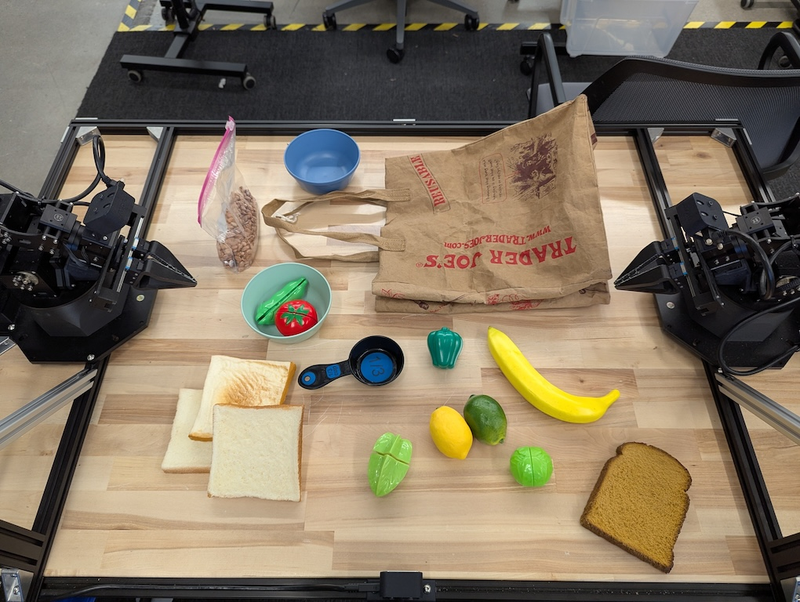

In [57]:
# @title Pointing to Undefined Objects

img = get_image_resized("aloha-arms-table.png")

prompt = textwrap.dedent("""\
    Point to no more than 10 items in the image. The label returned should be an
    identifying name for the object detected.

    The answer should follow the JSON format:
    [{"point": <point>, "label": <label1>}, ...]

    The points are in [y, x] format normalized to 0-1000.""")

start_time = time.time()
json_output = call_gemini_robotics_er(img, prompt)

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")
IPython.display.HTML(generate_point_html(img, json_output))

```json
[
  {"point": [759, 316], "label": "bread"},
  {"point": [703, 246], "label": "bread"},
  {"point": [631, 303], "label": "bread"},
  {"point": [823, 804], "label": "bread"},
  {"point": [770, 483], "label": "starfruit"},
  {"point": [619, 660], "label": "banana"}
]
```

Total processing time: 2.7466 seconds



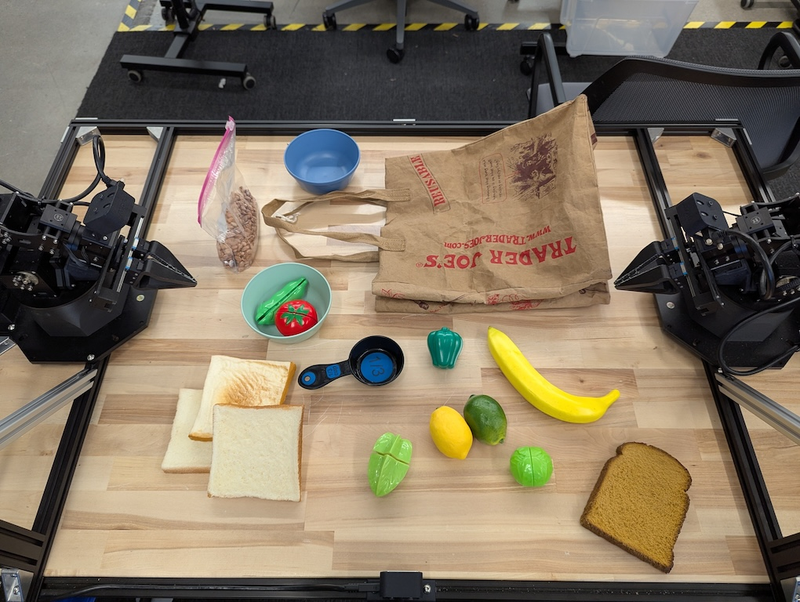

In [58]:
# @title Pointing to Defined Objects

img = get_image_resized("aloha-arms-table.png")

queries = [
    "bread",
    "starfruit",
    "banana",
]

prompt = textwrap.dedent(f"""\
Get all points matching the following objects: {', '.join(queries)}. The label
returned should be an identifying name for the object detected.

The answer should follow the JSON format:
[{{"point": <point>, "label": <label1>}}, ...]

The points are in [y, x] format normalized to 0-1000.
""")

start_time = time.time()
json_output = call_gemini_robotics_er(img, prompt)

points_data = []
try:
  data = json.loads(json_output)
  points_data.extend(data)
except json.JSONDecodeError:
  print("Warning: Invalid JSON response. Skipping.")

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")
IPython.display.HTML(generate_point_html(img, json.dumps(points_data)))

```json
[
  {"point": [507, 368], "label": "fruit"},
  {"point": [693, 558], "label": "fruit"},
  {"point": [678, 608], "label": "fruit"},
  {"point": [619, 663], "label": "fruit"}
]
```

Total processing time: 1.5331 seconds



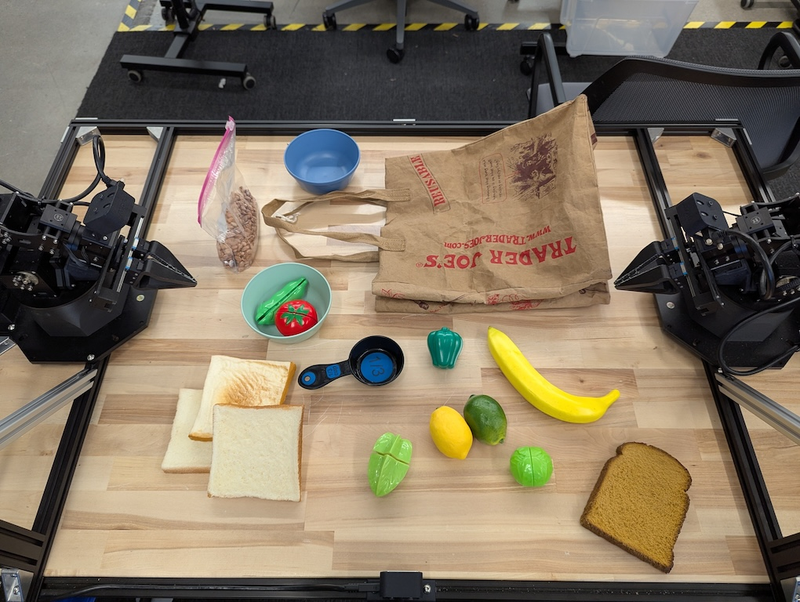

In [59]:
# @title Point to all instances of an object based on more abstract description (e.g. "fruit")

points_data = []
img = get_image_resized("aloha-arms-table.png")

prompt = textwrap.dedent(f"""\
        Get all points for fruit. The label returned should be an identifying
        name for the object detected.

        The answer should follow the json format:
        [{{"point": <point>, "label": <label1>}}, ...]

        The points are in [y, x] format normalized to 0-1000.""")

start_time = time.time()
json_output = call_gemini_robotics_er(img, prompt)

try:
  data = json.loads(json_output)
  points_data.extend(data)
except json.JSONDecodeError:
  print(f"Warning: Invalid JSON response, skipping.")

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")
IPython.display.HTML(generate_point_html(img, json.dumps(points_data)))

```json
[
  {"point": [500, 521], "label": "game board slot"},
  {"point": [500, 592], "label": "game board slot"},
  {"point": [500, 658], "label": "game board slot"},
  {"point": [600, 521], "label": "game board slot"},
  {"point": [600, 592], "label": "game board slot"},
  {"point": [600, 658], "label": "game board slot"},
  {"point": [700, 521], "label": "game board slot"},
  {"point": [700, 592], "label": "game board slot"},
  {"point": [700, 658], "label": "game board slot"}
]
```
```json
[
  {"point": [564, 420], "label": "X game piece"},
  {"point": [645, 336], "label": "X game piece"},
  {"point": [471, 788], "label": "X game piece"},
  {"point": [549, 839], "label": "X game piece"}
]
```

Total processing time: 3.3617 seconds



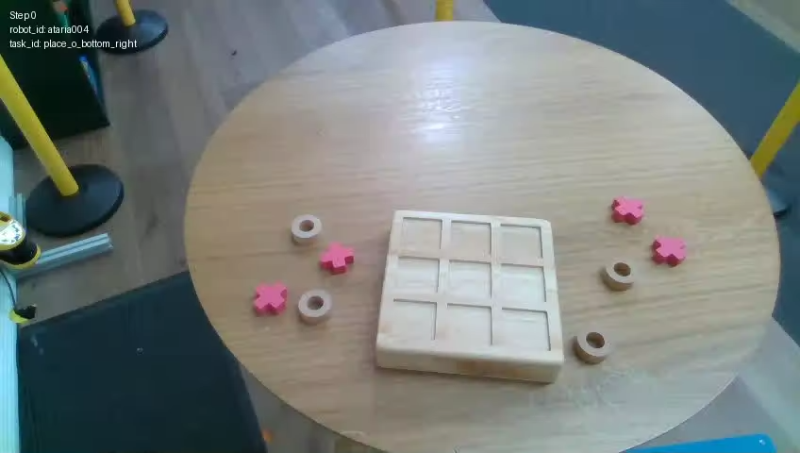

In [60]:
# @title Point to all instances of an object

points_data = []
img = get_image_resized("gameboard.png")

queries = [
    "game board slot",
    "X game piece",
]

start_time = time.time()
for obj in queries:
  prompt = textwrap.dedent(f"""\
      Get all points matching {obj}. The label returned should be an identifying
      name for the object detected.

      The answer should follow the JSON format:
      [{{"point": <point>, "label": <label1>}}, ...]

      The points are in [y, x] format normalized to 0-1000.""")
  json_output = call_gemini_robotics_er(img, prompt)

  try:
    data = json.loads(json_output)
    points_data.extend(data)
  except json.JSONDecodeError:
    print(f"Warning: Invalid JSON response for {obj}. Skipping.")
    continue

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")
IPython.display.HTML(generate_point_html(img, json.dumps(points_data)))

In [ ]:
# @title Pointing to certain parts of an object in serial
img = get_image_resized("aloha-arms-table.png")
points_data = []

queries = [
    ("paper bag", "handles"),
    ("banana", "the stem"),
    ("banana", "center"),
    ("starfruit", "center"),
    ("lime", "center"),
    ("light blue bowl", "rim"),
    ("dark blue bowl", "rim"),
    ("measuring cup", "rim"),
    ("measuring cup", "handle"),
    ("bowl", "tomato"),
]

start_time = time.time()
for obj, part in queries:
  prompt = POINT_PROMPT_TEMPLATE.replace("$object", obj).replace("$part", part)

  json_output = call_gemini_robotics_er(img, prompt)

  try:
    data = json.loads(json_output)
    points_data.extend(data)
  except json.JSONDecodeError:
    print(f"Warning: Invalid JSON response for {obj}, {part}. Skipping.")
    continue

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")
IPython.display.HTML(generate_point_html(img, json.dumps(points_data)))

As you can see in the example above, pointing to these objects in a loop can take a moment (e.g. 15 seconds). When possible, it is recommended that you run your queries in parallel to improve response time, as you can see in the following example.

In [61]:
# @title Pointing to certain parts of an object in parallel

img = get_image_resized("aloha-arms-table.png")
points_data = []

queries = [
    ("paper bag", "handles"),
    ("banana", "the stem"),
    ("banana", "center"),
    ("starfruit", "center"),
    ("lime", "center"),
    ("light blue bowl", "rim"),
    ("dark blue bowl", "rim"),
    ("measuring cup", "rim"),
    ("measuring cup", "handle"),
    ("bowl", "tomato"),
]

def process_query(obj, part):
  prompt = POINT_PROMPT_TEMPLATE.replace("$object", obj).replace("$part", part)
  json_output = call_gemini_robotics_er(img, prompt)
  try:
    data = json.loads(json_output)
    return data
  except json.JSONDecodeError:
    print(f"Warning: Invalid JSON response for {obj}, {part}. Skipping.")
    return []

start_time = time.time()
with concurrent.futures.ThreadPoolExecutor() as executor:
  results = executor.map(
      lambda query: process_query(query[0], query[1]), queries
  )

for result in results:
  points_data.extend(result)

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")
IPython.display.HTML(generate_point_html(img, json.dumps(points_data)))

```json
[
  {"point": [564, 616], "label": "the stem of the banana"}
]
```
```json
[
  {"point": [380, 420], "label": "handles"}
]
```
```json
[
  {"point": [609, 688], "label": "center of the banana"}
]
```
```json
[
  {"point": [303, 403], "label": "rim"}
]
```
```json
[
  {"point": [772, 482], "label": "starfruit"}
]
```
```json
[
  {"point": [704, 609], "label": "lime"}
]
```
```json
[
  {"point": [521, 368], "label": "tomato"}
]
```
```json
[
  {"point": [611, 401], "label": "handle of the measuring cup"}
]
```
```json
[
  {"point": [607, 479], "label": "rim of the measuring cup"}
]
```


ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10\nPlease retry in 29.66319808s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-robotics-er-1.5-preview', 'location': 'global'}, 'quotaValue': '10'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '29s'}]}}

In [62]:
# @title Counting by Pointing

img = get_image_resized("washer.png")

prompt = textwrap.dedent("""\
    Point to each washer in the box. Return the answer in the format:
    [{"point": <point>, "label": <label1>}, ...]

    The points are in [y, x] format normalized to 0-1000.""")

start_time = time.time()
json_output = call_gemini_robotics_er(img, prompt)

try:
  data = json.loads(json_output)
  print(f"count: {len(data)}")
except json.JSONDecodeError:
  print("Error: Could not decode JSON response from the model.")

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")
IPython.display.HTML(generate_point_html(img, json_output))

ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10\nPlease retry in 24.33040174s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-robotics-er-1.5-preview'}, 'quotaValue': '10'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '24s'}]}}

In [ ]:
# @title Pointing to Defined Objects in a GIF

gif_path = "aloha-pen.gif"
try:
  gif = Image.open(gif_path)
  print(f"Successfully loaded GIF: {gif_path}")
except FileNotFoundError:
  print(f"Error: GIF file not found at {gif_path}")
  raise

frames = extract_frames(gif)

# Define the objects to query
queries = [
    "pen (on desk)",
    "pen (in robot hand)",
    "laptop (opened)",
    "laptop (closed)",
]

prompt = textwrap.dedent(f"""\
Point to the following objects in the provided image: {", ".join(queries)}.

The answer should follow the JSON format:
[{{"point": <point>, "label": <label1>}}, ...]

The points are in [y, x] format normalized to 0-1000.

If no objects are found, return an empty JSON list [].""")


# Send every 10th frame as a separate request for the sake of time
analyzed_frames_data = []
frame_step = 10

for i in range(0, len(frames), frame_step):
  frame_index = i
  frame = frames[frame_index]
  print(f"Processing frame {frame_index+1}/{len(frames)}...")

  try:
    image_response = client.models.generate_content(
        model=MODEL_ID,
        contents=[frame, prompt],
        config=types.GenerateContentConfig(
            temperature=0.5,
            thinking_config=types.ThinkingConfig(thinking_budget=0),
        ),
    )

    try:
      json_output = parse_json(image_response.text)
      frame_points = json.loads(json_output)
      analyzed_frames_data.append(frame_points)
      print(
          f"  Successfully parsed {len(frame_points)} points for frame"
          f" {frame_index+1}."
      )
    except json.JSONDecodeError as e:
      print(
          f"  Error decoding JSON for frame {frame_index+1}: {e}. Appending"
          " empty list."
      )
      analyzed_frames_data.append([])
    except Exception as e:
      print(
          "  An unexpected error occurred processing frame"
          f" {frame_index+1} response: {e}. Appending empty list."
      )
      analyzed_frames_data.append([])

  except Exception as e:
    print(
        f"  Error generating content for frame {frame_index+1}: {e}. Appending"
        " empty list."
    )
    analyzed_frames_data.append([])


print(f"Collected point data for {len(analyzed_frames_data)} analyzed frames.")

points_data_all_frames = populate_points_for_all_frames(
    len(frames), frame_step, analyzed_frames_data
)
print(f"Populated point data for {len(points_data_all_frames)} total frames.")


modified_frames = overlay_points_on_frames(frames, points_data_all_frames)
display_gif(modified_frames)

# Object Detection and Bounding Boxes

In [ ]:
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/aloha-arms-table.png -O aloha-arms-table.png -q

In [ ]:
# @title 2D Bounding boxes

img = get_image_resized("aloha-arms-table.png")

prompt = textwrap.dedent("""\
      Return bounding boxes as a JSON array with labels. Never return masks or
      code fencing. Limit to 25 objects. Include as many objects as you can
      identify on the table.
      If an object is present multiple times, name them according to their
      unique characteristic (colors, size, position, unique characteristics,
      etc..).
      The format should be as follows:
      [{"box_2d": [ymin, xmin, ymax, xmax], "label": <label for the object>}]
      normalized to 0-1000. The values in box_2d must only be integers.
""")

start_time = time.time()
json_output = call_gemini_robotics_er(img, prompt)

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")

plot_bounding_boxes(img, json_output)
img

# Trajectories

In [ ]:
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/aloha_desk.png -O aloha_desk.png -q
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/particles.jpg -O particles.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/livingroom.jpeg -O livingroom.jpeg -q

In [ ]:
# @title Simple Trajectory Planning

img = get_image_resized("aloha_desk.png")
points_data = []

prompt = textwrap.dedent("""\
    Place a point on the red pen, then 15 points for the trajectory of moving
    the red pen to the top of the organizer on the left.

    The points should be labeled by order of the trajectory, from '0' (start
    point at left hand) to <n> (final point).

    The answer should follow the JSON format:
    [{"point": <point>, "label": <label1>}, ...]

    The points are in [y, x] format normalized to 0-1000.""")

start_time = time.time()
config=types.GenerateContentConfig(temperature=0.5)
json_output = call_gemini_robotics_er(img, prompt, config)

try:
  data = json.loads(json_output)
  points_data.extend(data)
except json.JSONDecodeError:
  print("Warning: Invalid JSON response. Skipping.")

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")
IPython.display.HTML(generate_point_html(img, json.dumps(points_data)))

In [ ]:
# @title Path for Brushing Particles

img = get_image_resized("particles.jpg")
points_data = []

prompt = textwrap.dedent("""\
    Point to the the blue brush and a list of 10 points covering the region of
    particles. Ensure that the points are spread evenly over the particles to
    create a smooth trajectory.

    Label the points from 1 to 10 based on the order that they should be
    approached in the trajectory of cleaning the plate. Movement should start
    from the brush.

    The answer should follow the JSON format:
    [{"point": <point>, "label": <label1>}, ...]

    The points are in [y, x] format normalized to 0-1000.""")

start_time = time.time()
config=types.GenerateContentConfig(temperature=0.5)
json_output = call_gemini_robotics_er(img, prompt, config)

try:
  data = json.loads(json_output)
  points_data.extend(data)
except json.JSONDecodeError:
  print("Warning: Invalid JSON response. Skipping.")

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")
IPython.display.HTML(generate_point_html(img, json.dumps(points_data)))

In [ ]:
# @title Obstacle-avoidance trajectory planning

img = get_image_resized("livingroom.jpeg")
points_data = []

prompt = textwrap.dedent("""\
    Find the most direct collision-free trajectory of 10 points on the floor
    between the current view origin and the green ottoman in the back left.
    The points should avoid all other obstacles on the floor.

    The answer should follow the JSON format:
    [{"point": <point>, "label": <label1>}, ...]

    The points are in [y, x] format normalized to 0-1000.
    """)

start_time = time.time()
config=types.GenerateContentConfig(temperature=0.5)
json_output = call_gemini_robotics_er(img, prompt, config)

try:
  data = json.loads(json_output)
  points_data.extend(data)
except json.JSONDecodeError:
  print("Warning: Invalid JSON response. Skipping.")

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")
IPython.display.HTML(generate_point_html(img, json.dumps(points_data)))

# Spatial Reasoning

In [ ]:
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/clear_space.png -O clear_space.png -q
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/desk_organization.mp4 -O desk_organization.mp4
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/bookshelf.jpeg -O bookshelf.jpeg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/cart.png -O cart.png -q
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/sockets.jpeg -O sockets.jpeg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/weights.jpeg -O weights.jpeg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/lunch.png -O lunch.png -q

In [ ]:
# @title Item to remove to make room for laptop

img = get_image_resized("clear_space.png")

prompt = textwrap.dedent("""\
    Point to the object that I need to remove to make room for my laptop.

    The answer should follow the JSON format:
    [{"point": <point>, "label": <label1>}, ...]

    The points are in [y, x] format normalized to 0-1000.""")

start_time = time.time()
json_output = call_gemini_robotics_er(img, prompt)

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")
IPython.display.HTML(generate_point_html(img, json_output))

In [ ]:
# @title Orchestrating: Packing a Lunch

img = get_image_resized("lunch.png")
prompt = textwrap.dedent("""\
    Explain how to pack the lunch box and lunch bag. Point to each object that
    you refer to.

    Each point should be in the format:
    [{"point": [y, x], "label": }]
    where the coordinates are normalized between 0-1000.
    """)

start_time = time.time()
json_output = call_gemini_robotics_er(img, prompt)

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")
img

In [ ]:
# @title Empty electrical sockets

img = get_image_resized("sockets.jpeg")
prompt = textwrap.dedent("""\
    Point to the unobstructed empty sockets.

    The answer should follow the JSON format:
    [{"point": <point>, "label": <label1>}, ...]

    The points are in [y, x] format normalized to 0-1000.""")

start_time = time.time()
json_output = call_gemini_robotics_er(img, prompt)

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")
IPython.display.HTML(generate_point_html(img, json_output))

In [ ]:
# @title Limiting item lift (3LB limit)
img = get_image_resized("weights.jpeg")

prompt = textwrap.dedent("""\
    I am a robot with a payload of 3LBs. Point to all the objects in the image I
    am physically able to pick up.

    The answer should follow the JSON format:
    [{"point": <point>, "label": <label1>}, ...]

    The points are in [y, x] format normalized to 0-1000.""")

start_time = time.time()
config=types.GenerateContentConfig(
    temperature=0.5,
    thinking_config=types.ThinkingConfig(thinking_budget=-1),
)
json_output = call_gemini_robotics_er(img, prompt, config)

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")
IPython.display.HTML(generate_point_html(img, json_output))

In [ ]:
# @title Video Analysis

myfile = client.files.upload(file="/content/desk_organization.mp4")
while myfile.state == "PROCESSING":
  print(".", end="")
  time.sleep(1)
  myfile = client.files.get(name=myfile.name)

if myfile.state.name == "FAILED":
  raise ValueError(myfile.state.name)

print("Uploaded")

prompt = textwrap.dedent("""\
    Describe in detail each step of finishing the task. Breaking it down by
    timestamp, output in JSON format with keys "start_timestamp",
    "end_timestamp" and "description".""")

start_time = time.time()

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[myfile, prompt],
    config=types.GenerateContentConfig(
        temperature=0.5,
        thinking_config=types.ThinkingConfig(thinking_budget=-1),
    ),
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTotal processing time: {elapsed_time:.4f} seconds")

print(response.text)

video_widget = widgets.Video.from_file("/content/desk_organization.mp4")
display.display(video_widget)

In [ ]:
# @title Video Analysis: Time Range

conversation_history = [
    {"role": "user", "parts": [{"text": prompt}]},
    {"role": "model", "parts": [{"text": response.text}]},
]

chat = client.chats.create(model=MODEL_ID, history=conversation_history)

prompt = textwrap.dedent("""\
    Zoom into second 15 to 22 and provide a per-second breakdown of what is
    happening in the same format.""")

start_time = time.time()

response = chat.send_message([prompt, myfile])

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTotal processing time: {elapsed_time:.4f} seconds")

print(response.text)

In [ ]:
# @title Finding the fourth row of shelves

img = get_image_resized("bookshelf.jpeg")

prompt = textwrap.dedent("""\
    Return bounding boxes as a JSON array with labels highlighting all cubbies
    in the fourth row of shelves.

    The format should be as follows:
    [{"box_2d": [ymin, xmin, ymax, xmax], "label": <label for the object>}]

    normalized to 0-1000. The values in box_2d must only be integers.""")

start_time = time.time()
config=types.GenerateContentConfig(temperature=0.5)
json_output = call_gemini_robotics_er(img, prompt, config)

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")
plot_bounding_boxes(img, json_output)
img

In [ ]:
# @title Finding shelves with specific items

img = get_image_resized("bookshelf.jpeg")

prompt = textwrap.dedent("""\
    "I need to blow my nose."
    Find the cubby that can help.

    The format should be as follows:
    [{"box_2d": [ymin, xmin, ymax, xmax], "label": <label for the object>}]

    normalized to 0-1000. The values in box_2d must only be integers.""")

start_time = time.time()
config=types.GenerateContentConfig(temperature=0.5)
json_output = call_gemini_robotics_er(img, prompt, config)

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")
plot_bounding_boxes(img, json_output)
img

In [ ]:
# @title Counting items with thinking

img = get_image_resized("cart.png")

prompt = textwrap.dedent("""\
    How many items are inside of the cart basket?
    Please share your reasoning.""")

start_time = time.time()
config=types.GenerateContentConfig(temperature=0.5)
json_output = call_gemini_robotics_er(img, prompt, config)

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")
img

In [ ]:
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/initial_state_1.png -O initial_state_1.png -q
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/initial_state_2.png -O initial_state_2.png -q
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/initial_state_3.png -O initial_state_3.png -q
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/initial_state_4.png -O initial_state_4.png -q
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/current_state_1.png -O current_state_1.png -q
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/current_state_2.png -O current_state_2.png -q
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/current_state_3.png -O current_state_3.png -q
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/current_state_4.png -O current_state_4.png -q

In [ ]:
# @title Multi-view correspondence and Success Detection

initial_state_1 = Image.open("initial_state_1.png")
initial_state_2 = Image.open("initial_state_2.png")
initial_state_3 = Image.open("initial_state_3.png")
initial_state_4 = Image.open("initial_state_4.png")
current_state_1 = Image.open("current_state_1.png")
current_state_2 = Image.open("current_state_2.png")
current_state_3 = Image.open("current_state_3.png")
current_state_4 = Image.open("current_state_4.png")

prompt = textwrap.dedent("""\
    For this task, you will see a robot or human trying to perform the task of
    putting the mango into the brown container. You may see multiple camera
    views of the same scene. Some cameras are static and are mounted outside of
    the scene and some cameras are mounted on the robot arms and thus they are
    moving during the episode.

    The first 4 images show multiple camera views from the start of the episode
    (some time ago). The last 4 images show multiple camera views from the
    current moment in the episode (as it is now).

    Looking at these images and comparing the start of the episode with current
    state did the robot successfully perform the task "put the mango into the
    brown container"?

    Answer only with (1) yes or (2) no. Return the number (1) or (2) that best
    answers the question.""")

start_time = time.time()

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        initial_state_1,
        initial_state_2,
        initial_state_3,
        initial_state_4,
        current_state_1,
        current_state_2,
        current_state_3,
        current_state_4,
        prompt
    ],
    config=types.GenerateContentConfig(temperature=0.5),
)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nTotal processing time: {elapsed_time:.4f} seconds")
print(f"Success? {'Yes' if response.text == '(1)' else 'No'}")

# Code Execution

In [ ]:
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/air_quality.jpeg -O air_quality.jpeg -q

In [ ]:
# @title Zooming in on sections of an image for better readings

img = get_image_resized("air_quality.jpeg")

prompt = textwrap.dedent("""\
    What is the air quality reading? Using the code execution feature, zoom in
    on the image to take a closer look.""")


start_time = time.time()
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[img, prompt],
    config=types.GenerateContentConfig(
        temperature=0.5,
        tools=[types.Tool(code_execution=types.ToolCodeExecution)],
    ),
)

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")

for part in response.candidates[0].content.parts:
  if part.text is not None:
    print(part.text)
  if part.executable_code is not None:
    print(part.executable_code.code)
  if part.code_execution_result is not None:
    print(part.code_execution_result.output)

img

# Segmentation

In [ ]:
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/mango.png -O mango.png -q

In [ ]:
# @title Segmentation with robot gripper and item

img = get_image_resized("mango.png")

prompt = textwrap.dedent("""\
    Provide the segmentation masks for the following objects in this image:
    mango, left robot gripper finger, right robot gripper finger.

    The answer should follow the JSON format:
    [
      {
        "box_2d": [ymin, xmin, ymax, xmax],
        "label": "<label for the object>",
        "mask": "data:image/png;base64,<base64 encoded PNG mask>"
      },
      ...
    ]

    The box_2d coordinates should be normalized to 0-1000 and must be integers.
    The mask should be a base64 encoded PNG image where non-zero pixels indicate
    the mask.""")

start_time = time.time()
config=types.GenerateContentConfig(temperature=0.5)
print("Raw Model Response Text:")
json_output = call_gemini_robotics_er(img, prompt, config)

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")

try:
  segmentation_masks = parse_segmentation_masks(
      json_output, img_height=img.size[1], img_width=img.size[0]
  )
  print(f"Successfully parsed {len(segmentation_masks)} segmentation masks.")

  annotated_img = plot_segmentation_masks(
      img.convert("RGBA"), segmentation_masks
  )
  display.display(annotated_img)

except json.JSONDecodeError as e:
  print(f"Error decoding JSON response: {e}")
except Exception as e:
  print(f"An error occurred during mask processing or plotting: {e}")

# Task Orchestration

To demonstrate task orchestration with your own custom robot API, this example will introduce a mock API that can be used for a simple pick-and-place operation. Both the block and the container where the block should be placed will be located and highlighted, and then the series of functions provided to the API will be called with appropriate logic for performing the action. This will use an origin system with 0,0 in a corner rather than on the robot.

In [ ]:
!wget https://storage.googleapis.com/generativeai-downloads/images/robotics/er-1-5-example-colab/soarm-block.png -O soarm-block.png -q

In [ ]:
# @title Locate relevant objects

img = get_image_resized("soarm-block.png")
points_data = []

prompt = textwrap.dedent("""\
    Locate and point to the blue block and the orange bowl. The label returned
    should be an identifying name for the object detected.

    The answer should follow the JSON format:
    [{"point": <point>, "label": <label1>}, ...]

    The points are in [y, x] format normalized to 0-1000.""")

start_time = time.time()
json_output = call_gemini_robotics_er(img, prompt)

data = json.loads(json_output)
points_data.extend(data)

print(f"\nTotal processing time: {(time.time() - start_time):.4f} seconds")
IPython.display.HTML(generate_point_html(img, json_output))

In [ ]:
# @title Use location of relevant objects to call functions and perform pick-and-place

# Define the robot's origin point so coordinates can be based on robot location
# for movements rather than original origin from the corner.

def move(x, y, high):
  print(f"moving to coordinates: {x}, {y}, {15 if high else 5}")


def setGripperState(opened):
  print("Opening gripper" if opened else "Closing gripper")


def returnToOrigin():
  print("Returning to origin pose")


robot_origin_y = 300
robot_origin_x = 500

blue_block_point = None
orange_bowl_point = None

for item in points_data:
  if item.get("label") == "blue block":
    blue_block_point = item.get("point")
  elif item.get("label") == "orange bowl":
    orange_bowl_point = item.get("point")

if blue_block_point and orange_bowl_point:
  block_y, block_x = blue_block_point
  bowl_y, bowl_x = orange_bowl_point

  print(f"Blue block normalized coordinates (y, x): {block_y}, {block_x}")
  print(f"Orange bowl normalized coordinates (y, x): {bowl_y}, {bowl_x}")

  block_relative_x = block_x - robot_origin_x
  block_relative_y = block_y - robot_origin_y
  bowl_relative_x = bowl_x - robot_origin_x
  bowl_relative_y = bowl_y - robot_origin_y

  prompt = textwrap.dedent(f"""\
      You are a robotic arm with six degrees-of-freedom. You have the following
      functions available to you:

      def move(x, y, high):
        # Moves the arm to the given coordinates. The boolean value 'high' set
        # to True means the robot arm should be lifted above the scene for
        # avoiding obstacles during motion. 'high' set to False means the robot
        # arm should have the gripper placed on the surface for interacting with
        # objects.

      def setGripperState(opened):
        # Opens the gripper if opened set to true, otherwise closes the gripper

      def returnToOrigin():
        # Returns the robot to an initial state. Should be called as a cleanup
        # operation.

      The origin point for calculating the moves is at normalized point
      y={robot_origin_y}, x={robot_origin_x}. Use this as the new (0,0) for
      calculating moves, allowing x and y to be negative.

      Perform a pick and place operation where you pick up the blue block at
      normalized coordinates ({block_x}, {block_y}) (relative coordinates:
      {block_relative_x}, {block_relative_y}) and place it into the orange bowl
      at normalized coordinates ({bowl_x}, {bowl_y}) (relative coordinates:
      {bowl_relative_x}, {bowl_relative_y}).
      Provide the sequence of function calls as a JSON list of objects, where
      each object has a "function" key (the function name) and an "args" key
      (a list of arguments for the function).

      Also, include your reasoning before the JSON output.

      For example:
      Reasoning: To pick up the block, I will first move the arm to a high
      position above the block, open the gripper, move down to the block, close
      the gripper, lift the arm, move to a high position above the bowl, move
      down to the bowl, open the gripper, and then lift the arm back to a high
      position.""")

  start_time = time.time()
  config=types.GenerateContentConfig(temperature=0.5)
  print("Model Response:")
  json_output = call_gemini_robotics_er(img, prompt, config)

  try:
    function_calls = json.loads(json_output)

    print("\nExecuting Function Calls:")
    for call in function_calls:
      function_name = call.get("function")
      arguments = call.get("args", [])

      if function_name == "move":
        move(*arguments)
      elif function_name == "setGripperState":
        setGripperState(*arguments)
      elif function_name == "returnToOrigin":
        returnToOrigin()
      else:
        print(f"Unknown function: {function_name}")

  except json.JSONDecodeError:
    print("Error: Could not parse JSON response from the model.")
  except Exception as e:
    print(f"An error occurred during function execution: {e}")

else:
  print("Could not find coordinates for both blue block and orange bowl.")